In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split

from envs.createEnvs import createCSVEnv
from envs.environments import NeuralNetwork

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def csvEditor(max_duplicates, input_csv, output_csv): #deletes the duplicates in the csv file
    row_counts = {}
    max_duplicates=max_duplicates

    # Leer el archivo CSV y encontrar filas únicas
    with open(input_csv, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        header = next(csv_reader)  # Leer la fila de encabezado
        output_rows = [header]  # Lista para almacenar las filas de salida, incluida la fila de encabezado

        for row in csv_reader:
            # Eliminar la columna "step" (la primera columna) antes de verificar duplicados
            row_no_step = row[1:]
            # Convertir la fila a una cadena para verificar duplicados
            row_str = ",".join(row_no_step)
            # Contar cuántas veces aparece la fila
            if row_str not in row_counts:
                row_counts[row_str] = 1
            else:
                row_counts[row_str] += 1
            # Verificar si la fila aparece menos o igual al número máximo de veces permitidas
            if row_counts[row_str] <= max_duplicates:
                # Agregar la fila a las filas de salida
                output_rows.append(row)

    # Escribir las filas únicas en el archivo CSV de salida
    with open(output_csv, 'w', newline='') as csv_output:
        csv_writer = csv.writer(csv_output)
        csv_writer.writerows(output_rows)

In [14]:
shape = "14x14"

if shape == "5x5":
    n_rows, n_cols = 5, 5
    n_epochs_grid = 3000
    n_epochs_reward = 3000
    #input_csv = '../data/csv/history.csv'
    output_csv = '../data/csv/history.csv'
    grid_model_path = '../data/models/_modelo_entorno5x5.pt'
    reward_model_path = '../data/models/_modelo_recompensa5x5.pt'

elif shape == "14x14":
    n_rows, n_cols = 14, 14
    n_epochs_grid = 100000
    n_epochs_reward = 3000
    input_csv = '../data/csv/history14x14.csv'
    output_csv = '../data/csv/new14x14.csv'
    grid_model_path = '../data/models/_modelo_entorno14x14.pt'
    reward_model_path = '../data/models/_modelo_recompensa14x14.pt'
    csvEditor(4, input_csv, output_csv)

env = createCSVEnv(shape)#, randomStart=False, render=False)

c:\Users\el_sa\anaconda3\envs\TFG\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment grid-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [15]:
# Listas para almacenar los valores de las columnas del csv
sy_values = []
sx_values = []
a_values = []
sy1_values = []
sx1_values = []
reward_values = []

In [18]:
# Leer el archivo CSV
with open(output_csv, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # Quitar la primera fila donde están los nombres de las columnas

    for row in csv_reader:
        step, y, x, action, next_y, next_x, reward, done =  row
        sy_values.append(float(y))
        sx_values.append(float(x))
        a_values.append(float(action))
        sy1_values.append(float(next_y))
        sx1_values.append(float(next_x))
        reward_values.append(float(reward))

In [19]:
# Convertir las listas en NumPy arrays
sy_array = np.array(sy_values)
sx_array = np.array(sx_values)
a_array = np.array(a_values)
sy1_array = np.array(sy1_values)
sx1_array = np.array(sx1_values)
reward_array = np.array(reward_values)

In [20]:
input_data1 = np.column_stack((sy_array, sx_array, a_array))
target_data1 = np.column_stack((sy1_array, sx1_array))
input_data2 = input_data1
target_data2 = reward_array

In [21]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(input_data1, target_data1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(input_data2, target_data2, test_size=0.2, random_state=42)

In [22]:
if shape == "5x5":
    model1 = NeuralNetwork(3, 2)
    model2 = NeuralNetwork(3, 1)
elif shape == "14x14":
    model1 = NeuralNetwork(3, 2, 256, 128)
    model2 = NeuralNetwork(3, 1, 64, 64)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters())
optimizer2 = optim.Adam(model2.parameters())

In [23]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor1 = torch.tensor(X_train1, dtype=torch.float32)
y_train_tensor1 = torch.tensor(y_train1, dtype=torch.float32)
X_test_tensor1 = torch.tensor(X_test1, dtype=torch.float32)
y_test_tensor1 = torch.tensor(y_test1, dtype=torch.float32)

X_train_tensor2 = torch.tensor(X_train2, dtype=torch.float32)
y_train_tensor2 = torch.tensor(y_train2, dtype=torch.float32).view(-1, 1)  # Reshape the target tensor
X_test_tensor2 = torch.tensor(X_test2, dtype=torch.float32)
y_test_tensor2 = torch.tensor(y_test2, dtype=torch.float32).view(-1, 1)  # Reshape the target tensor

In [24]:
losses1 = []

for epoch in range(n_epochs_grid):
    # Forward pass
    outputs = model1(X_train_tensor1)
    loss = criterion(outputs, y_train_tensor1)
    
    # Backpropagation and optimization
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
    
    losses1.append(loss.item())

print("Modelo entrenado!")

Modelo entrenado!


In [25]:
# Evaluate the model on the test data
with torch.no_grad():
    test_outputs = model1(X_test_tensor1)
    test_loss = criterion(test_outputs, y_test_tensor1)
    print(f'Test loss: {test_loss.item()}')

Test loss: 0.025752676650881767


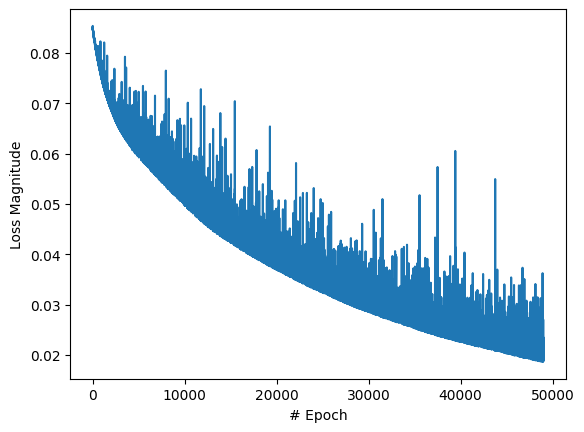

In [34]:
# Plot the training loss
plt.xlabel("# Epoch")
plt.ylabel("Loss Magnitude")
plt.plot(losses1)

In [27]:
# Perform predictions
grid = np.chararray((n_rows, n_cols), unicode=True)
for j in range(n_rows):
    for k in range(n_cols):
        for i in range(4):
            env_result = env.test([j, k, i])
            if type(env_result) == str:
                grid[j][k] = "#"
            else:
                grid[j][k] = "."
                test_input = torch.tensor([[float(j), float(k), float(i)]], dtype=torch.float32)
                resultado = model1(test_input)
                resultado = resultado.detach().numpy()
                if not(env_result[0] == round(resultado[0][0]) and env_result[1] == round(resultado[0][1])):
                    print([j, k, i])
                    print("El resultado es " + str(env_result))
                    print("El resultado es [" + str(round(resultado[0][0])) + " " + str(round(resultado[0][1])) + "]\n")


[0, 13, 2]
El resultado es [ 0 12]
El resultado es [0 13]

[0, 13, 3]
El resultado es [ 0 13]
El resultado es [0 14]

[2, 10, 2]
El resultado es [2 9]
El resultado es [2 10]

[3, 12, 2]
El resultado es [ 3 12]
El resultado es [3 11]

[6, 8, 2]
El resultado es [6 8]
El resultado es [6 7]

[6, 10, 0]
El resultado es [ 5 10]
El resultado es [6 10]

[7, 0, 1]
El resultado es [8 0]
El resultado es [7 0]

[7, 9, 1]
El resultado es [7 9]
El resultado es [8 9]

[7, 9, 2]
El resultado es [7 8]
El resultado es [7 9]

[8, 0, 1]
El resultado es [8 0]
El resultado es [9 0]

[8, 6, 1]
El resultado es [8 6]
El resultado es [9 6]

[8, 10, 2]
El resultado es [ 8 10]
El resultado es [8 9]

[9, 8, 0]
El resultado es [8 8]
El resultado es [9 8]

[9, 8, 2]
El resultado es [9 8]
El resultado es [9 7]

[10, 7, 0]
El resultado es [10  7]
El resultado es [9 7]

[10, 9, 1]
El resultado es [10  9]
El resultado es [11 9]

[10, 11, 1]
El resultado es [10 11]
El resultado es [11 11]

[10, 11, 2]
El resultado es [10

c:\Users\el_sa\anaconda3\envs\TFG\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.test to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.test` for environment variables or `env.get_wrapper_attr('test')` that will search the reminding wrappers.
  logger.warn(


In [28]:
torch.save(model1.state_dict(), grid_model_path)

Red para modelar la función de recompensa:

In [29]:
losses2 = []

for epoch in range(n_epochs_grid):
    # Forward pass
    outputs = model2(X_train_tensor2)
    loss = criterion(outputs, y_train_tensor2)
    
    # Backpropagation and optimization
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    
    losses2.append(loss.item())

print("Modelo entrenado!")

Modelo entrenado!


In [30]:
# Evaluate the model on the test data
with torch.no_grad():
    test_outputs = model2(X_test_tensor2)
    test_loss = criterion(test_outputs, y_test_tensor2)
    print(f'Test loss: {test_loss.item()}')

Test loss: 2.4305213841557816e-08


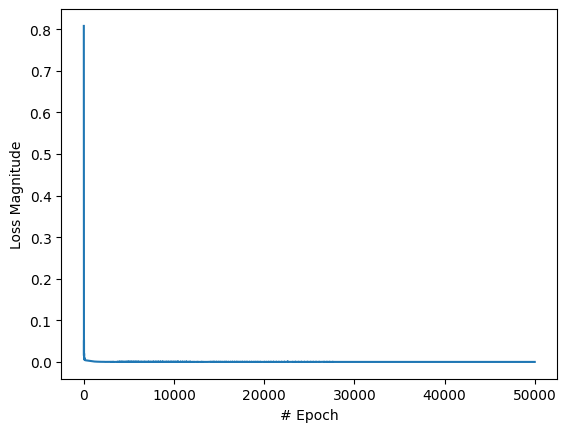

In [31]:
# Plot the training loss
plt.xlabel("# Epoch")
plt.ylabel("Loss Magnitude")
plt.plot(losses2)

In [32]:
# Perform predictions
for j in range(n_rows):
    for k in range(n_cols):
        for i in range(4):
            test_input = torch.tensor([[float(j), float(k), float(i)]], dtype=torch.float32)
            resultado = model2(test_input)
            resultado = resultado.detach().numpy()
            #print("El vector de entrada [y,x,a] es ", [j, k, i])
            #print("El resultado es " + str(resultado[0][0]) + " \t-> Redondeo: " + str(round(resultado[0][0])))
            if round(resultado[0][0]) == 1:
                print(str([j, k, i]) + "\t->\t" + str(round(abs(resultado[0][0]), 4)) + " \t-> Redondeo: " + str(round(resultado[0][0])))

[0, 10, 3]	->	0.5925 	-> Redondeo: 1
[0, 11, 3]	->	0.8432 	-> Redondeo: 1
[0, 12, 3]	->	1.0 	-> Redondeo: 1
[0, 13, 3]	->	0.9745 	-> Redondeo: 1
[1, 13, 0]	->	1.0 	-> Redondeo: 1


In [33]:
torch.save(model2.state_dict(), reward_model_path)